In [1]:
import scipy
import utils.preprocess as preprocess
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import solvers.pdas as pdas
import solvers.ipm as ipm
from timeit import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare Data

In [2]:
# Load Data
stim = scipy.io.loadmat("./data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("./data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [3]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [4]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

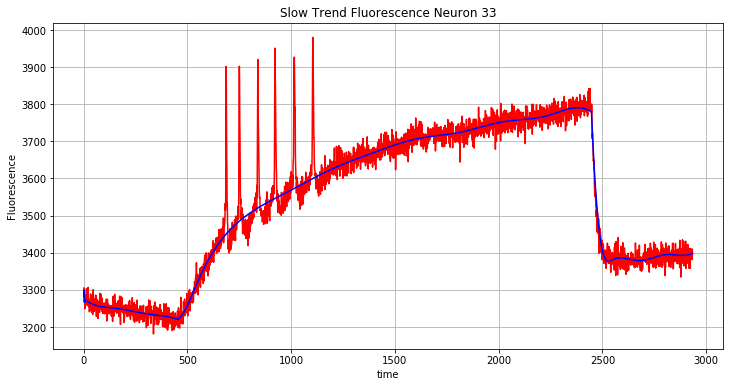

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Warm Start Comparison

In [6]:
idx = np.random.randint(0, N)
signal = signals[idx,:]

In [7]:
ipm_times = np.zeros(30)
pdas_times = np.zeros(30)
sizeData = np.arange(1,31) * T
lam = 500
for ndx in np.arange(1,31):
    target = np.tile(signal, ndx)
    def time_ipm():
        _, _, _ = ipm.solve(target, lam, False, 1e-4, 200, 0)
    def time_pdas():
        _, _, _ = pdas.solve(target, lam, 1000, 1)
    ipm_times[ndx-1] += timeit(time_ipm, number=3)/3
    pdas_times[ndx-1] += timeit(time_pdas, number=3)/3

In [8]:
ipm_tol_times = np.zeros(30)
pdas_ws_times = np.zeros(30)
sizeData = np.arange(1,31) * T
lam = 500
for ndx in np.arange(1,31):
    target = np.tile(signal, ndx)
    def time_ipm():
        _, _, _ = ipm.solve(target, lam, False, 1e2*ndx, 200, 0)
    _, warm_start, _ = pdas.solve(target, lam*1.1, 1000, 1)
    def time_pdas():
        _, _, _ = pdas.warm_start(target, lam, warm_start, 1000, 1)
    ipm_tol_times[ndx-1] += timeit(time_ipm, number=3)/3
    pdas_ws_times[ndx-1] += timeit(time_pdas, number=1)/1

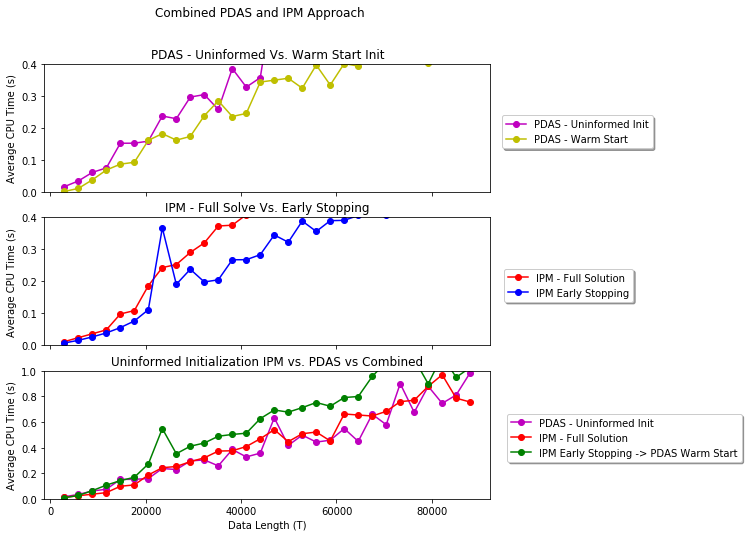

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=False)

ax = axs[0]
ax.plot(sizeData, pdas_times, marker='o', c='m')
ax.plot(sizeData, pdas_ws_times, marker='o', c='y')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('PDAS - Uninformed Vs. Warm Start Init')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['PDAS - Uninformed Init',
           'PDAS - Warm Start'], 
          loc='lower center', 
          bbox_to_anchor=(1.195, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[1]
ax.plot(sizeData, ipm_times, marker='o', c='r')
ax.plot(sizeData, ipm_tol_times, marker='o', c='b')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('IPM - Full Solve Vs. Early Stopping')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['IPM - Full Solution',
           'IPM Early Stopping'], 
          loc='lower center', 
          bbox_to_anchor=(1.175, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[2]
ax.plot(sizeData, pdas_times, marker='o', c='m')
ax.plot(sizeData, ipm_times, marker='o', c='r')
ax.plot(sizeData, ipm_tol_times + pdas_ws_times, marker='o', c='g')
ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Uninformed Initialization IPM vs. PDAS vs Combined')
ax.locator_params(nbins=6)

fig.suptitle('Combined PDAS and IPM Approach')
ax.legend(['PDAS - Uninformed Init',
           'IPM - Full Solution',
           'IPM Early Stopping -> PDAS Warm Start'], 
          loc='lower center', 
          bbox_to_anchor=(1.3, .25),
          ncol=1,
          fancybox=True,
          shadow=True)
#fig.tight_layout()
plt.show()

In [10]:
def time_pdas_long():
    _, _, _ = pdas.solve(np.tile(signal, 5000), 500, 1000, 1)

In [11]:
timeit(time_pdas_long, number=1)

0.48966417599876877

In [12]:
def time_ipm_long():
    _,_,_ = ipm.solve(np.tile(signal, 5000), 500, False, 1e-4, 200, 1)

In [13]:
timeit(time_ipm_long, number=1)

97.69117948699932

# Constrained Problem

In [14]:
import utils.noise
import numpy.random

In [15]:
noise_factor = 3
idx = np.random.randint(0, N)
raw = signals[idx,:]
raw_noise_std = utils.noise.estimate_noise([raw], summarize="mean")[0]
signal = np.sqrt(noise_factor**2 - 1) *raw_noise_std* np.random.randn(len(signal)) + raw
noise_std = utils.noise.estimate_noise([signal], summarize="mean")[0]
delta = (noise_std ** 2)

In [16]:
#r = .0000125
#x_hat, z_hat = ipm.solve(signal.copy(), r, True, 1e-4, 200, 1)
#lam = 3 * noise_std
#var_signal = np.mean(np.power(signal - np.median(signal),2))
var_signal = np.mean(np.power(signal,2))
#scale =  noise_std**2 / np.sqrt(var_signal - delta)
scale =  noise_std**2 / np.sqrt(np.var(signal) - delta)
lam = 3 * scale
x_hat, z_hat, iter_ = ipm.solve(signal.copy(), lam, False, 1e-4, 200, 1)

In [17]:
np.mean(np.power(signal - x_hat, 2))/delta

0.8698093332544529

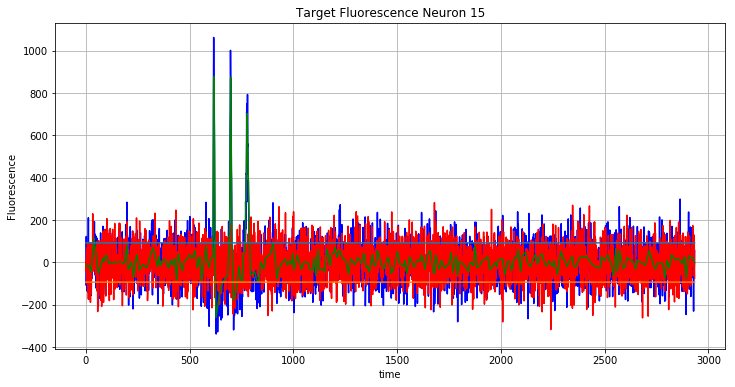

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal, 'b')
ax.plot(np.arange(T), numpy.random.randn(len(signal))*noise_std, 'r')
ax.plot(np.arange(T), np.array(x_hat), 'g')
#ax.plot(np.arange(T), noise_std * 3 * np.ones(len(signal)))
ax.plot(np.arange(T), np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
ax.plot(np.arange(T), -1*np.median(np.abs(x_hat - np.median(x_hat))) * 5 * np.ones(len(signal)))
ax.set(xlabel='time', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [19]:
target = signal.copy()
lams = np.logspace(np.log(3),np.log(20),25, base=np.e) * scale
grid = np.log(1 + (lams))
mses = np.zeros(len(lams))
x_hat, z_hat, iter_ = ipm.solve(target, lams[0], False, 1e-4, 200, 1)
mses[0] = np.mean(np.power(signal - x_hat, 2))
for ldx, lam in enumerate(lams[1:]):
    x_hat, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)
    mses[ldx + 1] = np.mean(np.power(signal - x_hat, 2))

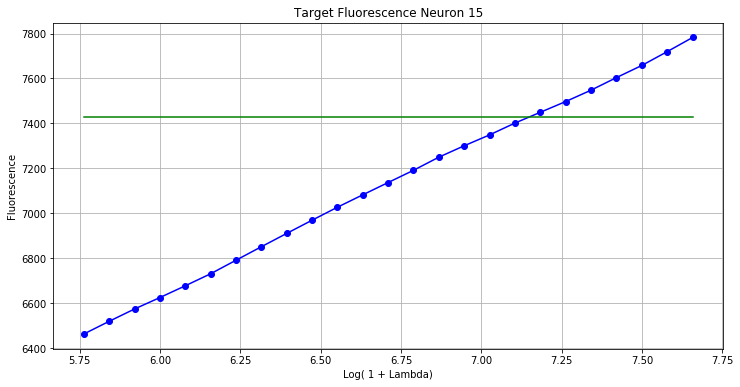

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(lams/scale, mses, 'b')
#ax.plot(lams/scale, np.ones(len(lams))*delta, 'g')
ax.plot(grid, mses, 'b', marker='o')
ax.plot(grid, np.ones(len(lams))*delta, 'g')
ax.set(xlabel='Log( 1 + Lambda)', ylabel='Fluorescence',
       title='Target Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

In [21]:
np.log(1 + lams[-1]) - np.log(1+lams[0])

1.8944450459881939

In [22]:
grid[-1] - grid[0]

1.8944450459881939

In [23]:
int_width = np.log(20 + (1/scale))- np.log(3 + (1/scale))

In [24]:
tau = int_width / 25

In [25]:
tau

0.07577780183952774

In [26]:
lams[10] - lams[9]

53.14298033138027

In [27]:
idx = 9
lams_plus = np.exp(np.log(lams[idx] + 1) - tau) - 1
lams_plus

598.8550545267022

In [28]:
lams_plus

598.8550545267022

In [29]:
lams[idx - 1]

596.9734143894663

In [30]:
target = signal.copy()
_, warm_start, iter_ = pdas.solve(target, lams[0], 500, 1)
def test_ws():
    _, z_hat, iter_ = pdas.warm_start(target, lams[0], warm_start, 1000, 1)
    for lam in lams[1:]:
        _, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)

In [31]:
timeit(test_ws, number=1)/1

0.03889037599947187

In [32]:
target = signal.copy()
_, warm_start, iter_ = pdas.solve(target, lams[-1], 500, 1)
def test_ws():
    _, z_hat, iter_ = pdas.warm_start(target, lams[-1], warm_start, 1000, 1)
    for lam in lams[-2::-1]:
        _, z_hat, iter_ = pdas.warm_start(target, lam, z_hat, 1000, 1)

In [33]:
timeit(test_ws, number=1)/1

0.09842823000144563

In [34]:
def test_naive():
    for lam in lams[1:]:
        _, z_init, iter_ = ipm.solve(target, lam, False, 1e-4, 200, 1)

In [35]:
timeit(test_naive, number=10)/10

0.23249195129974395